## 1. Configuration and Setup

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import *
from scripts.loading import *
from scripts.formating import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

print("Libraries loaded successfully!")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Libraries loaded successfully!


In [33]:

CONFIG = {
    'n_samples': 100000,                    # Number of samples to load
    'use_balanced_class_weight': True,      # Handle class imbalance
    'reduce_bin_size': False,               # Try larger bins (50 instead of 30)
    'improve_tfidf': True,                  # Use better TF-IDF params
    'use_random_forest': True,             # Try RandomForest instead of Logistic
    'use_numerical_features': False,        # Add numerical features to TF-IDF
}

print(CONFIG)
# Paths
MODEL_SAVE_PATH = "./bin_classification_model.pkl"
VECTORIZER_SAVE_PATH = "./bin_classification_vectorizer.pkl"
SCALER_SAVE_PATH = "./bin_classification_scaler.pkl"

# Year processing
MIN_YEAR = 1465
MAX_YEAR = 2025
BIN_SIZE = 50 if CONFIG['reduce_bin_size'] else 30
print(f"Using bin size of {BIN_SIZE} years.")
MODEL_TYPE = 'random_forest' if CONFIG['use_random_forest'] else 'logistic'

# Train/test split
TRAIN_TEST_RATIO = 0.8
RANDOM_STATE = 42
for key, value in CONFIG.items():
    print(f"{key}: {value}")
print(f"'Bin size': {BIN_SIZE}")
print(f"'Model type': {MODEL_TYPE}")


{'n_samples': 100000, 'use_balanced_class_weight': True, 'reduce_bin_size': False, 'improve_tfidf': True, 'use_random_forest': True, 'use_numerical_features': False}
Using bin size of 30 years.
n_samples: 100000
use_balanced_class_weight: True
reduce_bin_size: False
improve_tfidf: True
use_random_forest: True
use_numerical_features: False
'Bin size': 30
'Model type': random_forest


## 2. Data Loading and Preprocessing

In [34]:



print(f"Loading {CONFIG['n_samples']:,} samples...")
raw_dataset = load_wellcome_data(n_samples=CONFIG['n_samples'])
print(f"Loaded shape: {raw_dataset.shape}")

# Filter columns by missing value threshold
threshold = 0.80
missing_pct = raw_dataset.isnull().sum() / len(raw_dataset)
cols_to_keep = missing_pct[missing_pct <= threshold].index.tolist()

if "description" in raw_dataset.columns and "description" not in cols_to_keep:
    cols_to_keep.append("description")

filtered = raw_dataset[cols_to_keep]
print(f"After threshold filtering: {filtered.shape}")

# Remove unnecessary columns
columns_to_remove = [
    'id', 'workType_id', 'contributor_ids', 'subject_ids', 'language_ids',
    'identifiers', 'sierra_system_number', 'items_count', 'parts_count',
    'holdings_count', 'images_count', 'has_digitized_items',
    'availability_status', 'note_types'
]
necessary_df = filtered.copy().drop(columns=[c for c in columns_to_remove if c in filtered.columns])
print(f"After column removal: {necessary_df.shape}")
print(f"\nFinal columns: {list(necessary_df.columns)}")

Loading 100,000 samples...
Using existing file: /home/loulou/Work/ma1/cs-433/WellcomeML/data/works.json.gz
Loading 100000 samples from works.json.gz...


Parsing JSON lines:   0%|          | 0/100000 [00:00<?, ?it/s]

Parsing JSON lines: 100%|██████████| 100000/100000 [00:07<00:00, 13272.60it/s]



✓ Loaded 100,000 works
✓ DataFrame shape: (100000, 45)

Missing values (count):
precededBy_id              100000
genre_ids                  100000
production_date_from       100000
production_date_to         100000
precededBy_title           100000
succeededBy_id             100000
succeededBy_title          100000
issn                        98499
edition                     94659
alternativeTitles           94568
production_function         93089
wellcome_library_number     92820
lettering                   91751
thumbnail_url               90721
isbn                        84405
description                 75114
partOf_id                   74288
referenceNumber             62010
genres                      59766
partOf_title                48261
production_agents           44214
subject_ids                 40435
subjects                    40435
contributor_ids             33998
contributor_roles           33998
contributors                33998
production_places           32987
a

In [35]:
# Train/test split
print("\n" + "="*70)
print("STEP 2: TRAIN/TEST SPLIT")
print("="*70)

train = necessary_df.sample(frac=TRAIN_TEST_RATIO, random_state=RANDOM_STATE)
test = necessary_df.drop(train.index)

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Train/test ratio: {len(train)/len(necessary_df)*100:.1f}% / {len(test)/len(necessary_df)*100:.1f}%")


STEP 2: TRAIN/TEST SPLIT
Train shape: (80000, 16)
Test shape: (20000, 16)
Train/test ratio: 80.0% / 20.0%


## 3. Year Extraction and Binning

In [36]:
def extract_year_from_production_date(date_str):
    """Extract numeric year from messy production_date strings"""
    if pd.isna(date_str):
        return np.nan
    
    date_str = str(date_str)
    match = re.search(r'\b(1\d{3}|2\d{3})\b', date_str)
    
    if match:
        try:
            return int(match.group(1))
        except:
            pass
    
    return np.nan

# Extract years
print("\n" + "="*70)
print("STEP 3: EXTRACT AND PROCESS YEARS")
print("="*70)

train['production_date'] = train['production_date'].apply(extract_year_from_production_date)
test['production_date'] = test['production_date'].apply(extract_year_from_production_date)

print(f"Train valid dates: {train['production_date'].notna().sum()}/{len(train)}")
print(f"Test valid dates: {test['production_date'].notna().sum()}/{len(test)}")


STEP 3: EXTRACT AND PROCESS YEARS
Train valid dates: 72394/80000
Test valid dates: 18041/20000


In [37]:
def create_merged_column(df, exclude_cols=None):
    """Create MERGED column with format [COLUMN: {value}]"""
    if exclude_cols is None:
        exclude_cols = ["production_date", "thumbnail_url", "year_bin", "MERGED"]
    
    columns_to_merge = [c for c in df.columns if c not in exclude_cols]
    df_for_merge = df[columns_to_merge].copy()
    
    def format_row(row):
        parts = []
        for col in row.index:
            col_upper = col.upper()
            value = row[col]
            if pd.isna(value):
                value = ""
            parts.append(f"[{col_upper}: {{{value}}}]")
        return " ".join(parts)
    
    merged_text = df_for_merge.apply(format_row, axis=1)
    
    result = pd.DataFrame()
    result["MERGED"] = merged_text
    result["production_date"] = pd.to_numeric(df["production_date"], errors="coerce")
    
    if "year_bin" in df.columns:
        result["year_bin"] = df["year_bin"]
    
    return result.reset_index(drop=True)

# Create MERGED columns
print("\nCreating MERGED columns...")
if 'MERGED' not in train.columns:
    train_merged = create_merged_column(train)
    train = pd.concat([train.reset_index(drop=True), train_merged[['MERGED']]], axis=1)

if 'MERGED' not in test.columns:
    test_merged = create_merged_column(test)
    test = pd.concat([test.reset_index(drop=True), test_merged[['MERGED']]], axis=1)

print("✓ MERGED columns created")
print(f"Train columns: {list(train.columns)}")


Creating MERGED columns...
✓ MERGED columns created
Train columns: ['title', 'workType', 'description', 'physicalDescription', 'production_date', 'production_places', 'production_agents', 'contributors', 'contributor_roles', 'subjects', 'genres', 'languages', 'notes', 'partOf_title', 'partOf_id', 'referenceNumber', 'MERGED']


In [38]:
# Filter and preprocess years
def filter_years(df, is_train=True):
    df = df.copy()
    before = len(df)
    df = df[df['production_date'].notna()]
    removed = before - len(df)
    if removed > 0:
        print(f"Removed {removed} rows with missing years")
    
    # Clip years above max
    above_max = (df['production_date'] > MAX_YEAR).sum()
    if above_max > 0:
        df['production_date'] = df['production_date'].clip(upper=MAX_YEAR)
        print(f"Clipped {above_max} rows with years > {MAX_YEAR}")
    
    # Filter to valid range
    before = len(df)
    df = df[(df['production_date'] >= MIN_YEAR) & (df['production_date'] <= MAX_YEAR)]
    removed = before - len(df)
    if removed > 0:
        print(f"Filtered to {MIN_YEAR}-{MAX_YEAR}: removed {removed} rows")
    
    return df

train_proc = filter_years(train, is_train=True)
test_proc = filter_years(test, is_train=False)

print(f"\nFinal train shape: {train_proc.shape}")
print(f"Final test shape: {test_proc.shape}")
print(f"Train year range: {train_proc['production_date'].min():.0f} - {train_proc['production_date'].max():.0f}")
print(f"Test year range: {test_proc['production_date'].min():.0f} - {test_proc['production_date'].max():.0f}")

Removed 7606 rows with missing years
Clipped 2 rows with years > 2025
Filtered to 1465-2025: removed 42 rows
Removed 1959 rows with missing years
Clipped 2 rows with years > 2025
Filtered to 1465-2025: removed 7 rows

Final train shape: (72352, 17)
Final test shape: (18034, 17)
Train year range: 1465 - 2025
Test year range: 1466 - 2025


In [39]:
# Create year bins
def create_bins(df, bin_size):
    df = df.copy()
    df['year_bin'] = (df['production_date'] // bin_size) * bin_size
    df['year_bin_label'] = (df['year_bin'].astype(int).astype(str) + '-' +
                           (df['year_bin'] + bin_size - 1).astype(int).astype(str))
    return df

train_binned = create_bins(train_proc, BIN_SIZE)
test_binned = create_bins(test_proc, BIN_SIZE)

print(f"\nBin size: {BIN_SIZE} years")
print(f"Train unique bins: {train_binned['year_bin'].nunique()}")
print(f"Test unique bins: {test_binned['year_bin'].nunique()}")
print(f"\nTop 10 bins (training):")
print(train_binned['year_bin_label'].value_counts().head(10))


Bin size: 30 years
Train unique bins: 20
Test unique bins: 20

Top 10 bins (training):
year_bin_label
1980-2009    22463
1950-1979    16605
1920-1949     8055
1890-1919     5042
2010-2039     3162
1860-1889     2999
1830-1859     2210
1800-1829     2084
1650-1679     1474
1680-1709     1472
Name: count, dtype: int64


## 4. TF-IDF Vectorization

In [40]:
print("\n" + "="*70)
print("STEP 4: TF-IDF VECTORIZATION")
print("="*70)

if CONFIG['improve_tfidf']:
    print("Using improved TF-IDF parameters...")
    vectorizer = TfidfVectorizer(
        max_features=5000,
        min_df=5,
        max_df=0.7,
        ngram_range=(1, 3),
        strip_accents='unicode',
        lowercase=True,
        stop_words='english',
        sublinear_tf=True
    )
else:
    print("Using original TF-IDF parameters...")
    vectorizer = TfidfVectorizer(
        max_features=10000,
        min_df=3,
        max_df=0.8,
        ngram_range=(1, 2),
        strip_accents='unicode',
        lowercase=True,
        stop_words='english',
        sublinear_tf=True
    )

print("Fitting TF-IDF on training data...")
X_train_text = vectorizer.fit_transform(train_binned['MERGED'].fillna(''))

print("Transforming test data...")
X_test_text = vectorizer.transform(test_binned['MERGED'].fillna(''))

print(f"\n✓ Train shape: {X_train_text.shape}")
print(f"✓ Test shape: {X_test_text.shape}")
print(f"✓ Vocabulary size: {len(vectorizer.vocabulary_)}")


STEP 4: TF-IDF VECTORIZATION
Using improved TF-IDF parameters...
Fitting TF-IDF on training data...
Transforming test data...

✓ Train shape: (72352, 5000)
✓ Test shape: (18034, 5000)
✓ Vocabulary size: 5000


## 5. Feature Preparation

In [41]:
print("\n" + "="*70)
print("STEP 5: PREPARE FEATURES")
print("="*70)

if CONFIG['use_numerical_features']:
    print("Creating and combining with numerical features...")
    
    # Create numerical features
    for df in [train_binned, test_binned]:
        df['text_length'] = df['MERGED'].fillna('').str.len()
        df['word_count'] = df['MERGED'].fillna('').str.split().str.len()
        df['avg_word_length'] = df.apply(
            lambda row: row['text_length'] / max(row['word_count'], 1) if row['word_count'] > 0 else 0,
            axis=1
        )
    
    # Scale and combine
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(train_binned[['text_length', 'word_count', 'avg_word_length']].fillna(0))
    X_test_num = scaler.transform(test_binned[['text_length', 'word_count', 'avg_word_length']].fillna(0))
    
    X_train = hstack([X_train_text, X_train_num])
    X_test = hstack([X_test_text, X_test_num])
    
    print(f"✓ Combined features shape: {X_train.shape}")
else:
    print("Using TF-IDF only")
    X_train = X_train_text
    X_test = X_test_text
    scaler = None

# Prepare targets
y_train = train_binned['year_bin'].values
y_test = test_binned['year_bin'].values

print(f"\nFeatures ready:")
print(f"  Train: {X_train.shape}")
print(f"  Test: {X_test.shape}")
print(f"  Classes: {len(np.unique(y_train))}")
print("="*70)


STEP 5: PREPARE FEATURES
Using TF-IDF only

Features ready:
  Train: (72352, 5000)
  Test: (18034, 5000)
  Classes: 20


## 6. Model Training

In [42]:
print("\n" + "="*70)
print("STEP 6: TRAIN MODEL")
print("="*70)

if MODEL_TYPE == 'logistic':
    print("Training LogisticRegression...")
    model = LogisticRegression(
        max_iter=1500,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        C=0.1 if CONFIG['use_balanced_class_weight'] else 1.0,
        class_weight='balanced' if CONFIG['use_balanced_class_weight'] else None,
        solver='saga',
        verbose=1
    )
else:
    print("Training RandomForestClassifier...")
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced' if CONFIG['use_balanced_class_weight'] else None,
        max_features='sqrt',
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )

print(f"Using balanced class weights: {CONFIG['use_balanced_class_weight']}")
print(f"\nTraining on {X_train.shape[0]:,} samples with {X_train.shape[1]} features...")
model.fit(X_train, y_train)
print("✓ Training complete!")

# Training metrics
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"\nTraining Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print("="*70)


STEP 6: TRAIN MODEL
Training RandomForestClassifier...
Using balanced class weights: True

Training on 72,352 samples with 5000 features...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


✓ Training complete!


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s



Training Accuracy: 0.5310 (53.10%)


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.3s finished


## 7. Model Saving

In [43]:
print("\n" + "="*70)
print("STEP 7: SAVE MODEL")
print("="*70)

model_info = {
    'model': model,
    'model_type': MODEL_TYPE,
    'bin_size': BIN_SIZE,
}

with open(MODEL_SAVE_PATH, 'wb') as f:
    pickle.dump(model_info, f)
print(f"✓ Model saved: {MODEL_SAVE_PATH}")

with open(VECTORIZER_SAVE_PATH, 'wb') as f:
    pickle.dump(vectorizer, f)
print(f"✓ Vectorizer saved: {VECTORIZER_SAVE_PATH}")

if CONFIG['use_numerical_features'] and scaler:
    with open(SCALER_SAVE_PATH, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"✓ Scaler saved: {SCALER_SAVE_PATH}")

print("="*70)


STEP 7: SAVE MODEL
✓ Model saved: ./bin_classification_model.pkl
✓ Vectorizer saved: ./bin_classification_vectorizer.pkl


## 8. Predictions and Evaluation

In [44]:
print("\n" + "="*70)
print("STEP 8: MAKE PREDICTIONS")
print("="*70)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Add predictions to test dataframe
test_binned['predicted_year_bin'] = y_pred
test_binned['prediction_confidence'] = y_pred_proba.max(axis=1)
test_binned['predicted_year'] = y_pred + (BIN_SIZE / 2)
test_binned['error_years'] = abs(test_binned['production_date'] - test_binned['predicted_year'])

print(f"✓ Predictions complete: {len(y_pred):,} samples")
print("="*70)


STEP 8: MAKE PREDICTIONS


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


✓ Predictions complete: 18,034 samples


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished


In [45]:
print("\n" + "="*70)
print("EVALUATION METRICS")
print("="*70)

# Classification metrics
test_accuracy = accuracy_score(y_test, y_pred)
exact_match = (y_test == y_pred).sum()
within_bin = (np.abs(y_test - y_pred) <= BIN_SIZE).sum()

print(f"\nClassification Metrics:")
print(f"  Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Exact match: {exact_match:,}/{len(y_test):,} ({exact_match/len(y_test)*100:.2f}%)")
print(f"  Within ±{BIN_SIZE}y: {within_bin:,}/{len(y_test):,} ({within_bin/len(y_test)*100:.2f}%)")

# Regression metrics
mae = mean_absolute_error(test_binned['production_date'], test_binned['predicted_year'])
rmse = np.sqrt(mean_squared_error(test_binned['production_date'], test_binned['predicted_year']))
r2 = r2_score(test_binned['production_date'], test_binned['predicted_year'])

print(f"\nRegression Metrics:")
print(f"  MAE: {mae:.2f} years")
print(f"  RMSE: {rmse:.2f} years")
print(f"  R²: {r2:.4f}")

print(f"\nConfidence:")
print(f"  Mean: {test_binned['prediction_confidence'].mean():.3f}")
high_conf = (test_binned['prediction_confidence'] > 0.8).sum()
print(f"  High (>0.8): {high_conf:,} ({high_conf/len(test_binned)*100:.1f}%)")

print("="*70)


EVALUATION METRICS

Classification Metrics:
  Accuracy: 0.4856 (48.56%)
  Exact match: 8,758/18,034 (48.56%)
  Within ±30y: 14,586/18,034 (80.88%)

Regression Metrics:
  MAE: 28.79 years
  RMSE: 45.69 years
  R²: 0.8488

Confidence:
  Mean: 0.260
  High (>0.8): 218 (1.2%)


## 9. Visualizations


Generating visualizations...
✓ Visualizations saved to tfidf_evaluation.png


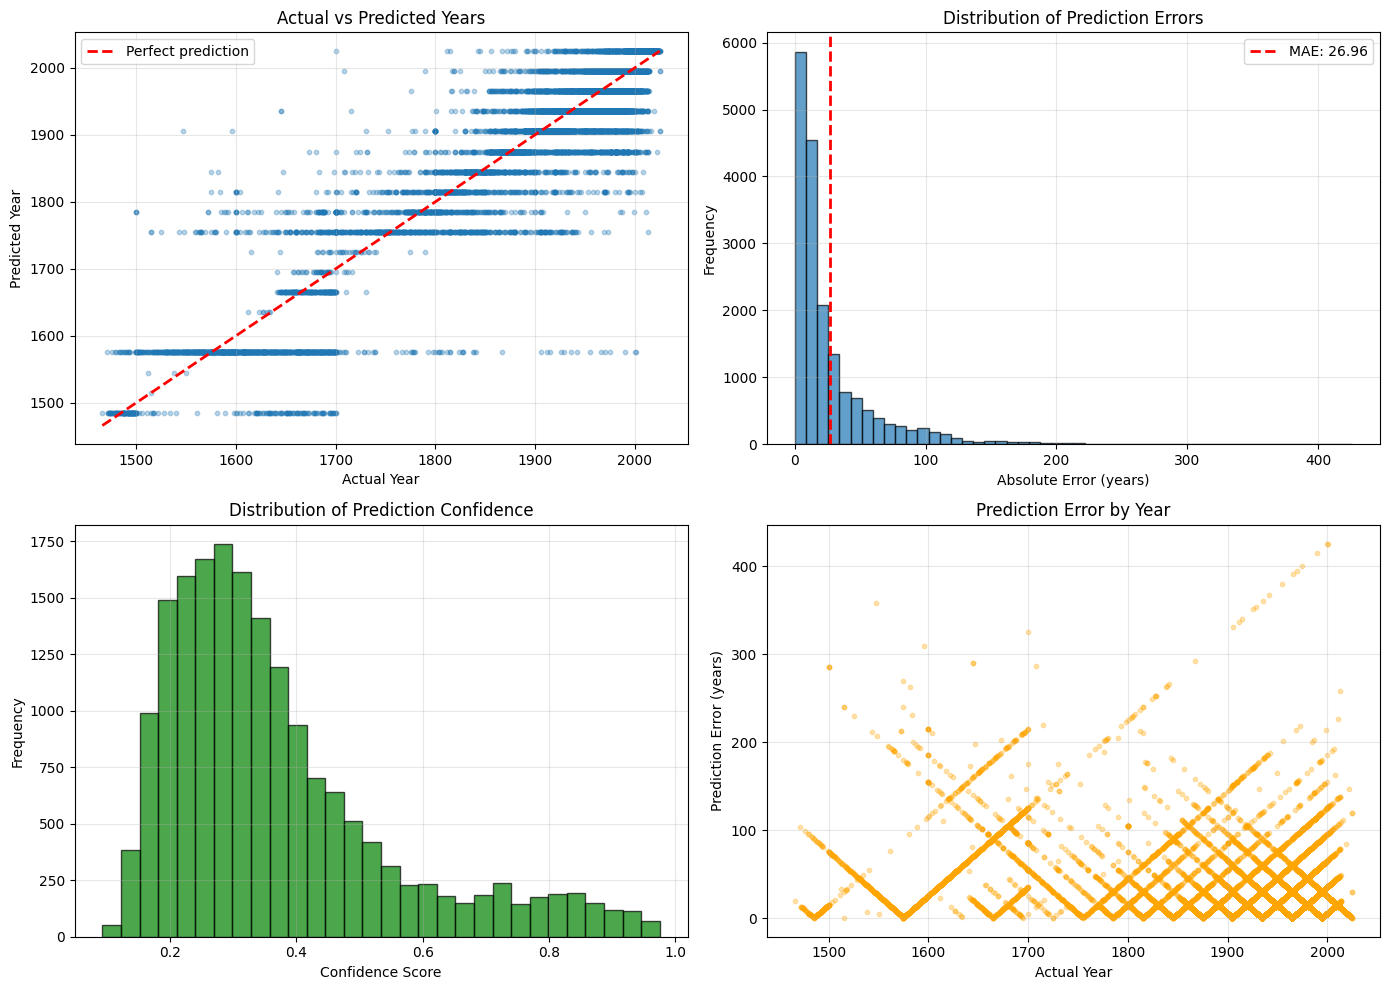

In [30]:
print("\nGenerating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Actual vs Predicted
axes[0, 0].scatter(test_binned['production_date'], test_binned['predicted_year'], alpha=0.3, s=10)
axes[0, 0].plot([test_binned['production_date'].min(), test_binned['production_date'].max()],
                [test_binned['production_date'].min(), test_binned['production_date'].max()],
                'r--', lw=2, label='Perfect prediction')
axes[0, 0].set_xlabel('Actual Year')
axes[0, 0].set_ylabel('Predicted Year')
axes[0, 0].set_title('Actual vs Predicted Years')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Error distribution
axes[0, 1].hist(test_binned['error_years'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(mae, color='r', linestyle='--', linewidth=2, label=f'MAE: {mae:.2f}')
axes[0, 1].set_xlabel('Absolute Error (years)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Prediction Errors')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Confidence distribution
axes[1, 0].hist(test_binned['prediction_confidence'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xlabel('Confidence Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Prediction Confidence')
axes[1, 0].grid(True, alpha=0.3)

# 4. Error by year
axes[1, 1].scatter(test_binned['production_date'], test_binned['error_years'], alpha=0.3, s=10, color='orange')
axes[1, 1].set_xlabel('Actual Year')
axes[1, 1].set_ylabel('Prediction Error (years)')
axes[1, 1].set_title('Prediction Error by Year')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./tfidf_evaluation.png', dpi=100, bbox_inches='tight')
print("✓ Visualizations saved to tfidf_evaluation.png")
plt.show()

## 10. Summary and Results

In [31]:

print(f"\nConfiguration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

print(f"\nData:")
print(f"  Training samples: {len(train_binned):,}")
print(f"  Test samples: {len(test_binned):,}")
print(f"  Number of year bins: {train_binned['year_bin'].nunique()}")

print(f"\nFeatures:")
print(f"  TF-IDF features: {len(vectorizer.vocabulary_):,}")
print(f"  Total features: {X_train.shape[1]:,}")

print(f"\nModel:")
print(f"  Type: {MODEL_TYPE}")
print(f"  Training accuracy: {train_accuracy:.2%}")
print(f"  Test accuracy: {test_accuracy:.2%}")
print(f"  Generalization gap: {(train_accuracy - test_accuracy):.2%}")

print(f"\nPerformance:")
print(f"  MAE: {mae:.2f} years")
print(f"  RMSE: {rmse:.2f} years")
print(f"  R² Score: {r2:.4f}")
print(f"  Avg Confidence: {test_binned['prediction_confidence'].mean():.3f}")

print(f"\nFiles saved:")
print(f"  Model: {MODEL_SAVE_PATH}")
print(f"  Vectorizer: {VECTORIZER_SAVE_PATH}")
if CONFIG['use_numerical_features'] and scaler:
    print(f"  Scaler: {SCALER_SAVE_PATH}")
print(f"  Evaluation plot: ./tfidf_evaluation.png")



Configuration:
  n_samples: 100000
  use_balanced_class_weight: True
  reduce_bin_size: False
  improve_tfidf: True
  use_random_forest: False
  use_numerical_features: False

Data:
  Training samples: 72,352
  Test samples: 18,034
  Number of year bins: 20

Features:
  TF-IDF features: 5,000
  Total features: 5,000

Model:
  Type: logistic
  Training accuracy: 54.49%
  Test accuracy: 52.70%
  Generalization gap: 1.79%

Performance:
  MAE: 26.96 years
  RMSE: 44.53 years
  R² Score: 0.8564
  Avg Confidence: 0.366

Files saved:
  Model: ./bin_classification_model.pkl
  Vectorizer: ./bin_classification_vectorizer.pkl
  Evaluation plot: ./tfidf_evaluation.png
